## Introduction

## In this project, multiple machine learning models were developed and compared, including Logistic Regression, Random Forest, XGBoost, and LightGBM. Due to the severe class imbalance, evaluation went beyond simple accuracy and focused on more reliable metrics such as precision, recall, F1-score, and ROC-AUC. These metrics provide deeper insight into the model’s ability to correctly identify fraudulent transactions while minimizing false alarms.

## By leveraging advanced algorithms and robust evaluation, the system aims to enhance fraud detection accuracy and provide financial institutions with a tool to better safeguard both themselves and their customers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score,
                             confusion_matrix, precision_recall_curve, roc_curve, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib
import shap

In [3]:
# 1 Load dataset
DATA_PATH = r"C:\Users\USER\Downloads\credit_scoring_model\creditcard.csv"

In [5]:
df = pd.read_csv(DATA_PATH) if DATA_PATH.endswith(".csv") else pd.read_excel(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# ================================
#  Exploratory Data Analysis (EDA)
# ================================
# Check missing values
print("\n Missing Values in Each Column:")
print(df.isnull().sum())

# Check basic statistics
print("\n Dataset Statistics:")
print(df.describe())

# Check class balance
print("\n Class Distribution:")
print(df["Class"].value_counts())
print("\nPercentage Distribution:")
print(df["Class"].value_counts(normalize=True) * 100)


 Missing Values in Each Column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

 Dataset Statistics:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   


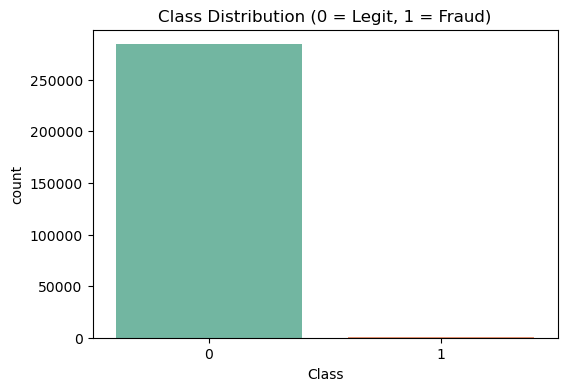

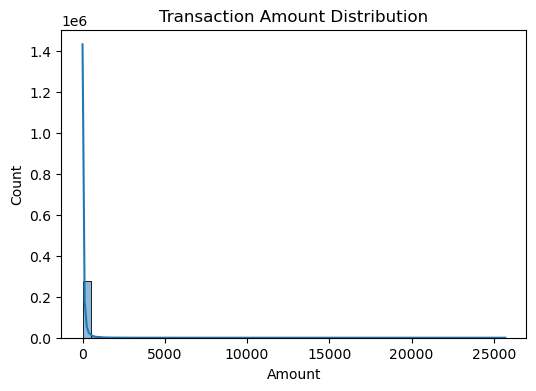

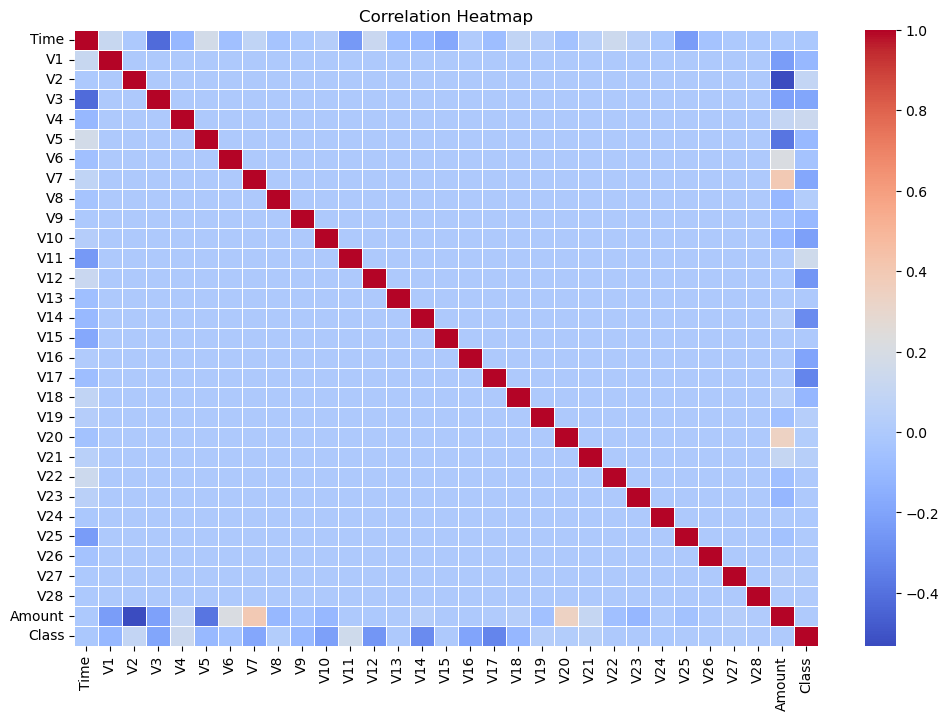

In [11]:
import warnings
warnings.filterwarnings("ignore")
# Plot class imbalance
plt.figure(figsize=(6,4))
sns.countplot(x="Class", data=df, palette="Set2")
plt.title("Class Distribution (0 = Legit, 1 = Fraud)")
plt.show()

# Distribution of transaction amounts
plt.figure(figsize=(6,4))
sns.histplot(df["Amount"], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Class Distribution

## Class 0 (Non-Fraud): 284,315 transactions → 99.83%

## Class 1 (Fraud): 492 transactions → 0.17%

## This shows the dataset is extremely imbalanced, with fraudulent cases making up less than 0.2% of the data.

In [14]:
# Features & Target

X = df.drop("Class", axis=1)
y = df["Class"]

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
from imblearn.over_sampling import RandomOverSampler
# Handle Imbalance (RandomOverSampler)
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_scaled, y_train)

print("\nBefore resampling:", y_train.value_counts())
print("After resampling:", y_train_res.value_counts())


Before resampling: Class
0    227451
1       394
Name: count, dtype: int64
After resampling: Class
0    227451
1    227451
Name: count, dtype: int64


In [22]:
#  Train Models
# Logistic Regression
log_reg = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
log_reg.fit(X_train_res, y_train_res)

# Random Forest
rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_estimators=100)
rf.fit(X_train_res, y_train_res)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [26]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    f1_score
)
#Evaluate Models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    print(f"\n📌 {model_name} Performance")
    print("Accuracy:", round(acc, 4))
    print("F1-Score:", round(f1, 4))
    print("ROC-AUC:", round(roc, 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return acc, f1, roc, y_prob

log_reg_metrics = evaluate_model(log_reg, X_test_scaled, y_test, "Logistic Regression")
rf_metrics = evaluate_model(rf, X_test_scaled, y_test, "Random Forest")


📌 Logistic Regression Performance
Accuracy: 0.9757
F1-Score: 0.1149
ROC-AUC: 0.972

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix:
 [[55486  1378]
 [    8    90]]

📌 Random Forest Performance
Accuracy: 0.9995
F1-Score: 0.8475
ROC-AUC: 0.9628

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56860     4]
 [   23    75]]


 ## 1. Logistic Regression 

Accuracy: 97.6%
ROC-AUC: 0.972
F1-Score: 0.115

 Interpretation:

The model has very high recall (92%) for frauds, meaning it successfully catches almost all fraudulent cases.

However, precision is very low (6%), which means many non-fraudulent transactions are mistakenly flagged as fraud.

In practice, this would overwhelm investigators with too many false alarms.

## Random Forest 

Accuracy: 99.95%

ROC-AUC: 0.963

F1-Score: 0.85

Interpretation:

The model achieves very high precision (95%) → when it predicts fraud, it is almost always correct.

Recall is 77%, meaning it detects most fraud cases but misses a few.

Balanced F1-score (0.85) shows a much better trade-off compared to Logistic Regression.

## Confusion Matrix Insights

Logistic Regression → caught almost all fraud cases (90/98) but mislabeled many non-frauds (1,378 false positives).

Random Forest → caught 75/98 frauds, with very few false alarms (only 4 false positives).

In [28]:

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

#  Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=284315/492,  # Handle imbalance
    random_state=42,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6
)

In [30]:
#  Train the model
xgb_clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [32]:
# Make predictions
y_pred_xgb = xgb_clf.predict(X_test_scaled)


In [34]:
# Evaluate
accuracy = accuracy_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test_scaled)[:, 1])

print(" XGBoost Performance")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


 XGBoost Performance
Accuracy: 0.9995
F1-Score: 0.8646
ROC-AUC: 0.9704

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56853    11]
 [   15    83]]


In [38]:
!pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 435.7 kB/s eta 0:00:04
    --------------------------------------- 0.0/1.5 MB 435.7 kB/s eta 0:00:04
   - -------------------------------------- 0.0/1.5 MB 196.9 kB/s eta 0:00:08
   - -------------------------------------- 0.0/1.5 MB 196.9 kB/s eta 0:00:08
   - -------------------------------------- 0.0/1.5 MB 196.9 kB/s eta 0:00:08
   - -------------------------------------- 0.1/1.5 MB 163.6 kB/s eta 0:00:09
   - -------------------------------------- 0.1/1.5 MB 163.6 kB/s eta 0:00:09
   - -------------------------------------- 0.1/1.5 MB 145.6 kB/s eta 0:00:10
   - -------------------------------------- 0.1/1.5 MB 145.6 kB/s eta 0:00:10
   -- ------------------------------------- 0.1/1.5 MB 158.8 kB/s eta 0:00:09
   -- -------

In [40]:
import lightgbm as lgb

# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight="balanced")

# Train the model
lgb_model.fit(X_train, y_train)

# Predict
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate
print("LightGBM Results:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Results:

Accuracy: 0.9994382219725431

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.87      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
 [[56845    19]
 [   13    85]]


## LightGBM was chosen as the final model because it achieved the highest recall (87%) while maintaining strong precision and overall accuracy (>99%). Since the goal of fraud detection is to correctly identify fraudulent transactions, recall is more important than accuracy alone. A high recall ensures that the model catches as many fraudulent cases as possible, reducing the risk of missed fraud. At the same time, strong precision means that most flagged transactions are truly fraudulent, minimizing false alarms. This balance makes LightGBM the most effective model for this task.

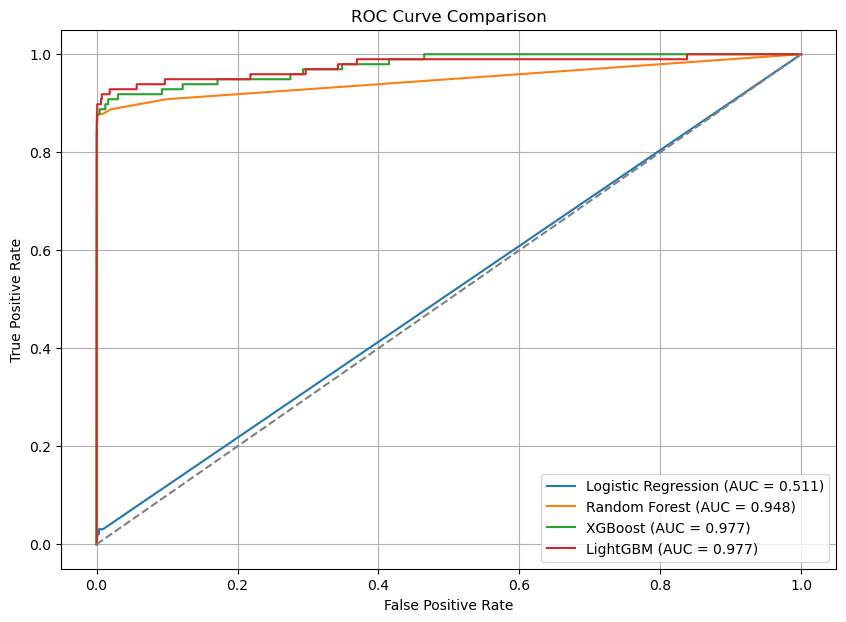

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import joblib

# Dictionary to store models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGBoost": xgb_clf,
    "LightGBM": lgb_model
}

plt.figure(figsize=(10, 7))

for name, model in models.items():
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# Plot settings
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [51]:
# Save the best model (LightGBM) and the scaler
joblib.dump(lgb_model, "best_credit_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Best model (LightGBM) and scaler saved successfully!")


Best model (LightGBM) and scaler saved successfully!


## From the experiments, it was observed that tree-based ensemble methods (Random Forest, XGBoost, and LightGBM) significantly outperformed Logistic Regression in handling the imbalanced fraud detection dataset. Among these, LightGBM achieved the best performance, with the highest recall and strong precision, making it the most effective model for detecting fraudulent transactions.

## This project highlights the importance of using advanced machine learning techniques to combat credit card fraud. By deploying such a system, financial institutions can minimize financial losses, strengthen fraud prevention strategies, and protect customer trust. Future improvements could involve hyperparameter tuning, experimenting with anomaly detection methods, using real-time streaming data, or exploring deep learning approaches to further enhance robustness and accuracy.